In [59]:
import pandas as pd
import numpy as np 
import sqlite3
import nltk
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import scipy as sp
import sqlite3
import re
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates

In [12]:
conn = sqlite3.connect("/Users/jackmackle/py_work/uranium-twitter-bot/storage/storage.db")
df = pd.read_sql_query("SELECT * FROM tweets", conn)
conn.close()

# VADER - No Cleaning

In [13]:
sid = SentimentIntensityAnalyzer()

In [14]:
tw_text_list = df["full_text"].tolist()
polarity_scores = list(map(sid.polarity_scores, tw_text_list))
compound = list(map(lambda x: x["compound"], polarity_scores))

In [15]:
df["compound_pol"] = compound

In [16]:
strip_date = list(map(lambda x: x.split()[0], df["created_at"].to_list()))
df["stripdate"] = strip_date

In [38]:
df_date_group = df[["stripdate", "compound_pol"]].groupby("stripdate", as_index=False).agg(['count','mean']).reset_index()

In [125]:
df_sput = pd.read_csv("sput-data.txt",
                      sep="\t",
                      index_col=None,
                      header=None)
df_dml = pd.read_csv("dml-data.txt",
                      sep="\t",
                      index_col=None,
                      header=None)

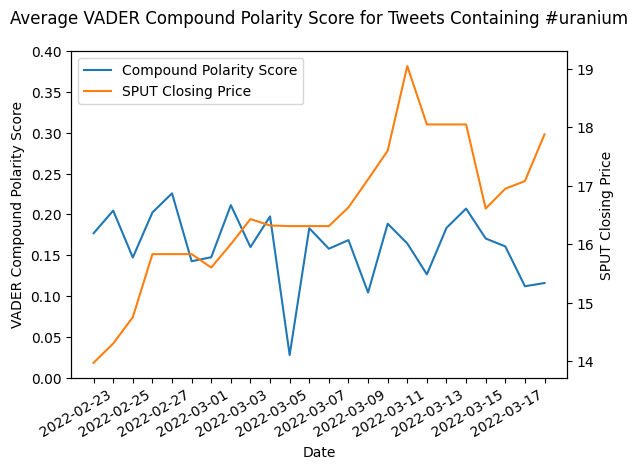

In [131]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(df_date_group["stripdate"],
         df_date_group["compound_pol"]["mean"],
         label="Compound Polarity Score")
fig.autofmt_xdate()
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
ax1.set_title("Average VADER Compound Polarity Score for Tweets Containing #uranium",
              pad=20)
ax1.set_ylabel("VADER Compound Polarity Score")
ax1.set_xlabel("Date")
ax1.set_ylim([0,.4])

ax2 = ax1.twinx()
ln2 = ax2.plot(df_date_group["stripdate"],
        df_sput[1],
        color="tab:orange",
        label="SPUT Closing Price")
ax2.set_ylabel("SPUT Closing Price")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

plt.show()

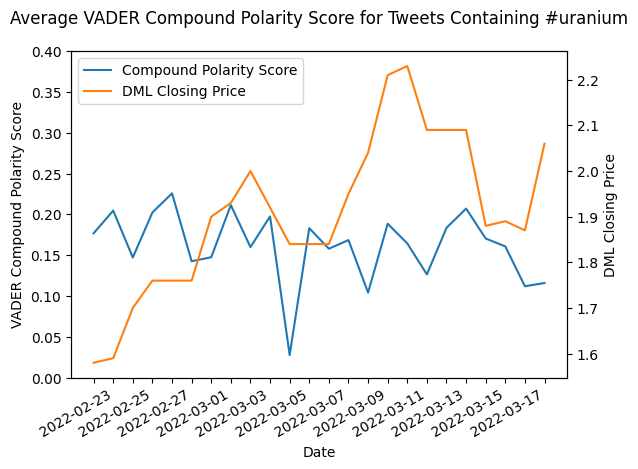

In [132]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(df_date_group["stripdate"],
         df_date_group["compound_pol"]["mean"],
         label="Compound Polarity Score")
fig.autofmt_xdate()
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
ax1.set_title("Average VADER Compound Polarity Score for Tweets Containing #uranium",
              pad=20)
ax1.set_ylabel("VADER Compound Polarity Score")
ax1.set_xlabel("Date")
ax1.set_ylim([0,.4])

ax2 = ax1.twinx()
ln2 = ax2.plot(df_date_group["stripdate"],
        df_dml[1],
        color="tab:orange",
        label="DML Closing Price")
ax2.set_ylabel("DML Closing Price")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

plt.show()

<AxesSubplot:xlabel='compound_pol', ylabel='Count'>

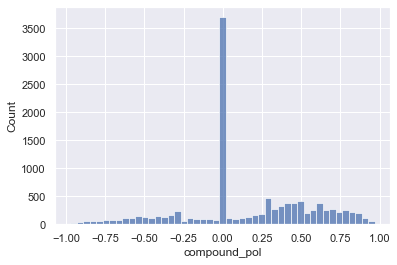

In [19]:
sns.histplot(data=df, x="compound_pol")

# VADER - Cleaning

In [20]:
df_clean = df

In [21]:
tw_text_list = df_clean["full_text"].tolist()

def remove_handles(text):
    r = re.findall("@[\w]*", text)
    for i in r:
        text = re.sub(i, "", text)
        
    return text

tw_text_list = list(map(remove_handles, tw_text_list))

def remove_links(text):
    r = re.findall("https?://[A-Za-z0-9./]*", text)
    for i in r:
        text = re.sub(i, "", text)
        
    return text

tw_text_list = list(map(remove_links, tw_text_list))

In [22]:
polarity_scores = list(map(sid.polarity_scores, tw_text_list))
compound = list(map(lambda x: x["compound"], polarity_scores))

In [23]:
df_clean["compound_pol"] = compound

<AxesSubplot:xlabel='compound_pol', ylabel='Count'>

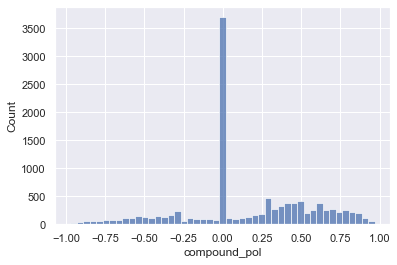

In [24]:
sns.histplot(data=df_clean, x="compound_pol")

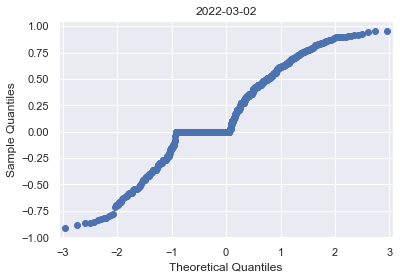

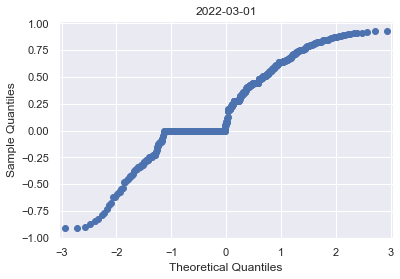

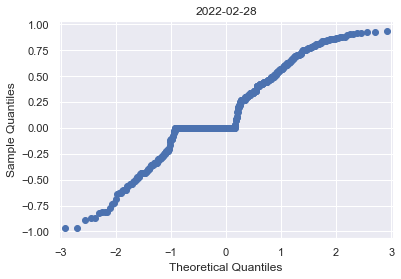

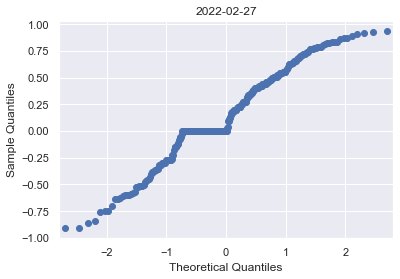

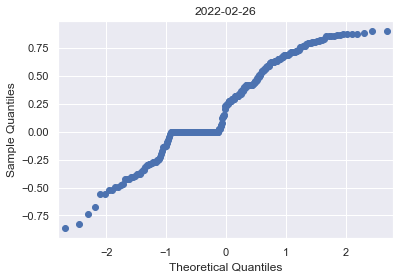

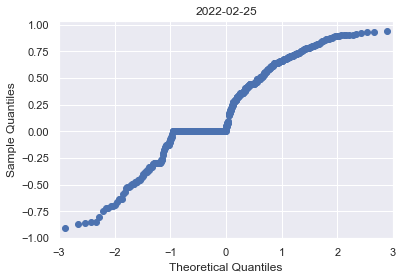

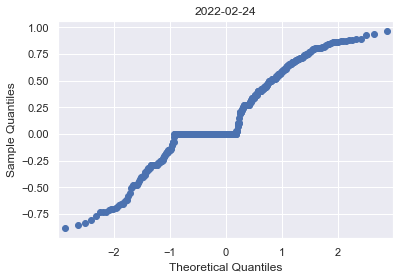

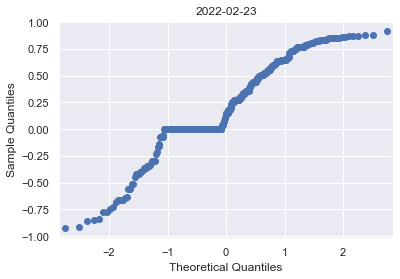

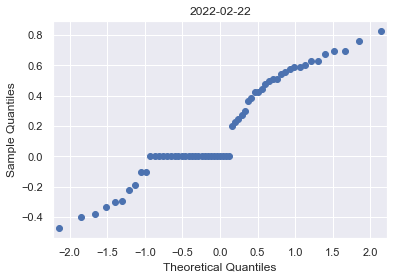

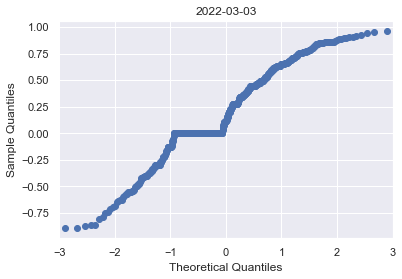

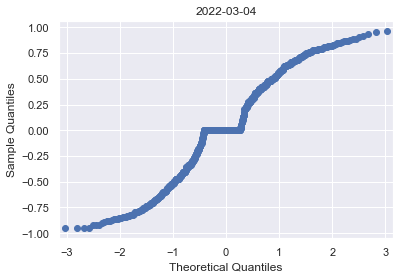

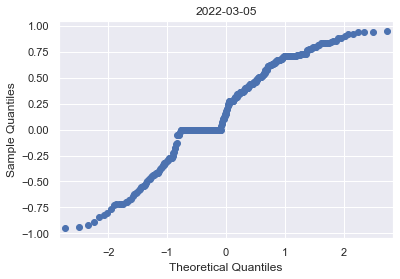

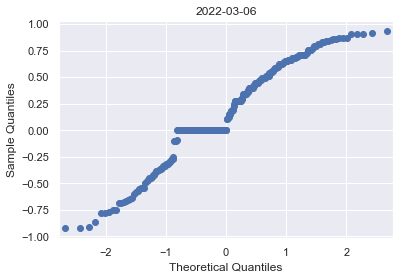

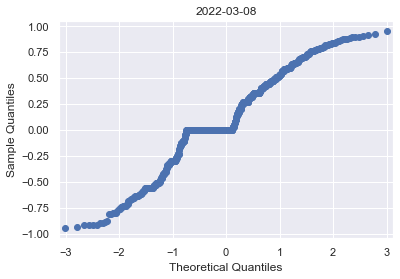

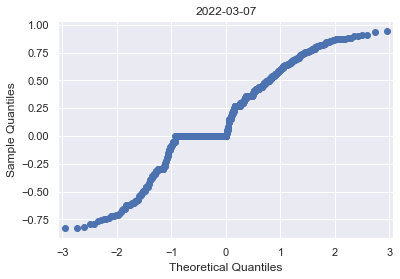

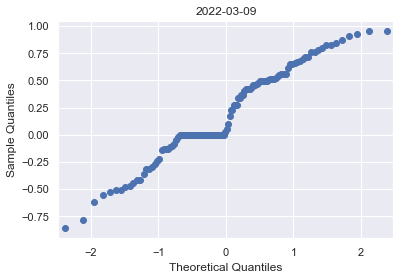

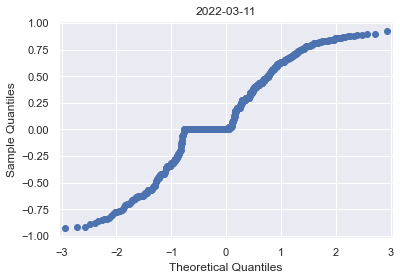

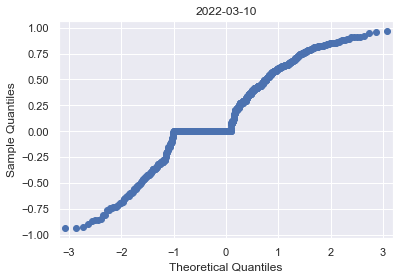

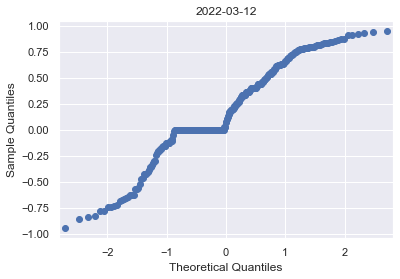

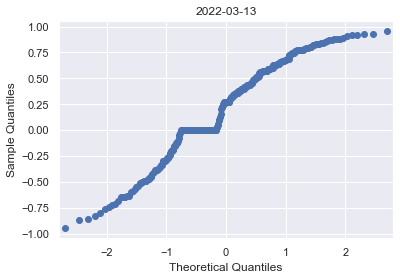

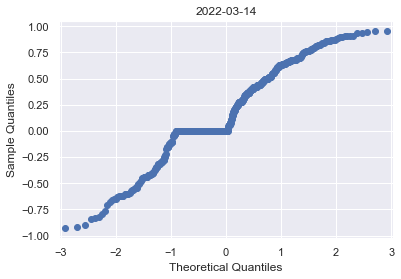

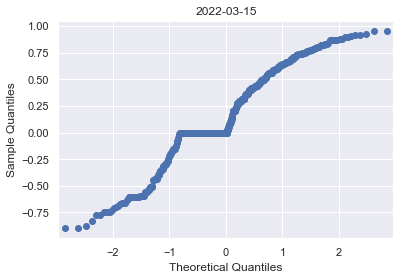

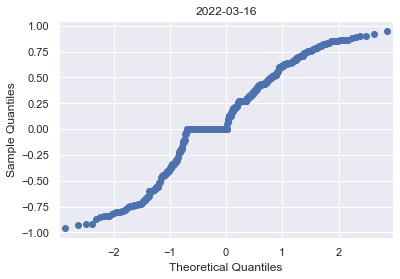

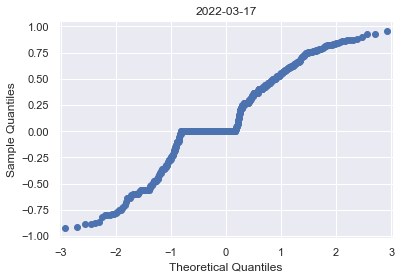

In [25]:
for i in df_clean['stripdate'].unique():
    fig = sm.qqplot(df_clean[df_clean['stripdate'] == i]['compound_pol'])
    plt.title(i)
    plt.show()

In [26]:
df_clean.columns

Index(['tweet_id', 'created_at', 'in_reply_to_status', 'full_text', 'verified',
       'retweet_count', 'user_id', 'user_name', 'user_followers_coubt',
       'compound_pol', 'stripdate'],
      dtype='object')

In [27]:
df_cbs = df_clean.groupby("user_name", as_index=False)["compound_pol"].mean()
df_cbs.sort_values(by="compound_pol", ascending=False)

,user_name,compound_pol
313,DMSeII4Mayor,0.9565
145,BRONinvestnet,0.9556
51,ASimpleTweetBot,0.9509
1012,SamTheCarpetMan,0.9401
763,MiningFan,0.9297
...,...,...
1890,saaedsabzian,-0.9136
565,Jamal74622325,-0.9178
1515,drizham,-0.9186
1983,tinlizzie71,-0.9493


In [28]:
#pd.to_datetime(pd.Series(['2022-02-27 19:15:57+00:00']), format="%m/%d/%Y")

strip_date = list(map(lambda x: x.split()[0], df_clean["created_at"].to_list()))
df_clean["stripdate"] = strip_date

In [29]:
df_clean[["stripdate", "compound_pol"]].groupby("stripdate", as_index=False).agg(['count','mean']).reset_index()

stripdate compound_pol          
                      count      mean
0   2022-02-22           61  0.176889
1   2022-02-23          336  0.204645
2   2022-02-24          490  0.147176
3   2022-02-25          520  0.202389
4   2022-02-26          279  0.225790
5   2022-02-27          287  0.142606
6   2022-02-28          573  0.147505
7   2022-03-01          600  0.211371
8   2022-03-02          637  0.159918
9   2022-03-03          530  0.197516
10  2022-03-04          814  0.027661
11  2022-03-05          317  0.183103
12  2022-03-06          266  0.157923
13  2022-03-07          636  0.168501
14  2022-03-08          761  0.104196
15  2022-03-09          116  0.188537
16  2022-03-10          957  0.164424
17  2022-03-11          599  0.126496
18  2022-03-12          299  0.183491
19  2022-03-13          284  0.207121
20  2022-03-14          575  0.170432
21  2022-03-15          453  0.160776
22  2022-03-16          474  0.111945
23  2022-03-17          577  0.115906

<AxesSubplot:xlabel='stripdate', ylabel='compound_pol'>

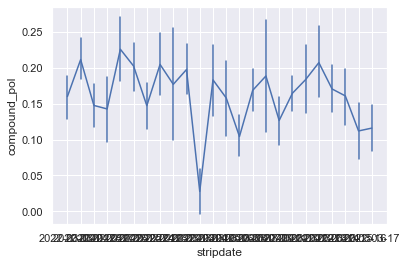

In [30]:
sns.lineplot(data=df_clean,
            x="stripdate",
            y="compound_pol",
            err_style="bars")